In [77]:
!pip install torchinfo

In [78]:
import torch
from torchvision import datasets, transforms
from torch import nn
from torchinfo import summary

import matplotlib.pyplot as plt

In [121]:
batch_size, hidden_size = 128, 128
input_size, seq_len = 28, 28
num_classes = 10
num_channels = 1

# Torch Imports

In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [123]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.CenterCrop(size=(input_size, seq_len)),
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ]
    )
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.CenterCrop(size=(input_size, seq_len)),
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ]
    )
)

In [124]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

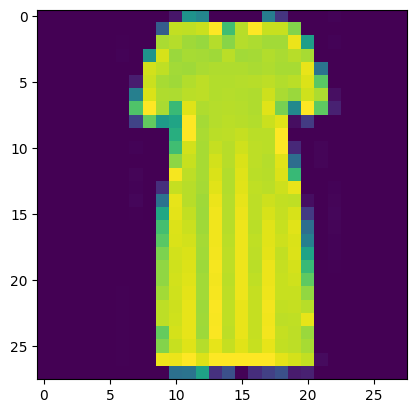

In [125]:
for (x, y) in train_dataloader:
    plt.imshow(x[0].squeeze())
    break

# RNN

In [318]:
def train_model(data, model, loss_fn, optimizer, epochs: int = 3, show_step: int = 100):
    count = 0
    n_total_steps = len(data)

    for epoch in range(epochs):
        for step, (images, labels) in enumerate(data):
            optimizer.zero_grad()

            train  = images.view(size=(-1, seq_len, input_size)).to(device)
            labels = labels.to(device)

            output, _ = model(train)

            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            count += 1

            if (step+1) % show_step == 0:
                print (f'Epoch [{epoch+1}/{epochs}], Step [{step+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        print('\n')

In [319]:
def accuracy(data, model):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in data:
            images = images.view(size=(-1, seq_len, input_size)).to(device)
            labels = labels.to(device)

            output, _ = model(images)

            _, predicted = torch.max(output.data, dim=1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = n_correct / n_samples
        return acc

## CustomRNN: LinearEx (Dense), RNNCellEx (memory_cell), RNNLayer (simpleRNN)

In [173]:
sample = next(iter(train_dataloader))[0].squeeze()

In [285]:
class LinearEx(nn.Module):
    __constants__ = ['in_features', 'out_features', 'bias']

    def __init__(self, in_features: int, out_features: int, bias: bool = True, device: str = 'cpu', **kwargs):
        super(LinearEx, self).__init__(**kwargs)

        self.use_bias = bias
        self.device = device

        self.weights = nn.Parameter(data=torch.randn(size=(out_features, in_features), device=device), requires_grad=True)
        if self.use_bias: self.bias = nn.Parameter(data=torch.randn(size=(out_features, 1), device=device), requires_grad=True)

    def forward(self, inputs: torch.Tensor):
        inputs = inputs.to(self.device)

        if self.use_bias:
            return torch.matmul(inputs, torch.transpose(self.weights, dim0=0, dim1=1)) + self.bias.squeeze()
        else: return torch.matmul(inputs, torch.transpose(self.weights, dim0=0, dim1=1))

torch.Size([128, 28, 128])


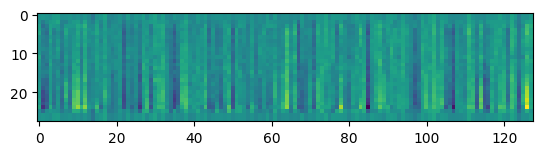

In [175]:
linear_layer = LinearEx(in_features=input_size, out_features=hidden_size, device=device)
layer_pred = linear_layer(sample)
print(layer_pred.size())
plt.imshow(layer_pred.detach().cpu()[0].squeeze())

In [492]:
class SimpleAttention1d(nn.Module):
    __constants__ = ['input_size']

    def __init__(self, input_size: int, device: str = 'cpu'):
        super(SimpleAttention1d, self).__init__()

        self.device = device

        self.linear = LinearEx(in_features=input_size, out_features=input_size, device=device)
        self.batch_norm = nn.BatchNorm1d(num_features=input_size, device=device)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs: torch.Tensor):
        inputs = inputs.to(self.device)

        logits = self.softmax(self.batch_norm(self.linear(inputs)))
        embeddings = torch.multiply(inputs, logits)

        return embeddings

In [493]:
def plot_results(image_1, image_2):
    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_subplot(1, 2, 1)
    plt.xticks([]), plt.yticks([])
    ax.imshow(image_1)

    ax = fig.add_subplot(1, 2, 2)
    plt.xticks([]), plt.yticks([])
    ax.imshow(image_2)

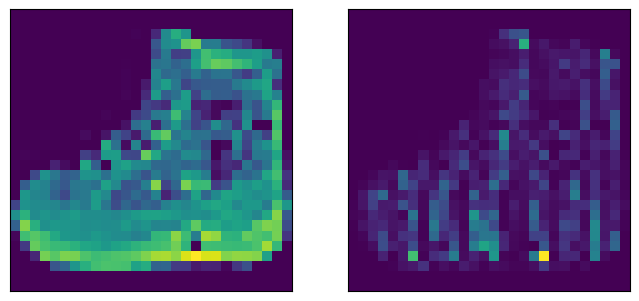

In [496]:
att_layer = SimpleAttention1d(input_size=input_size)
a_att = att_layer(sample[0]).detach()

plot_results(sample[0], a_att)

In [499]:
class RNNCellEx(nn.Module):
    __constants__ = ['input_size', 'hidden_size', 'bias', 'nonlinearity']

    def __init__(self, input_size: int, hidden_size: int, bias: bool = True, nonlinearity: str = 'tanh', device: str = 'cpu'):
        super(RNNCellEx, self).__init__()

        self.nonlinearity = nonlinearity

        self.in_to_hidden = LinearEx(in_features=input_size, out_features=hidden_size, bias=bias, device=device)
        self.hidden_to_hidden = LinearEx(in_features=hidden_size, out_features=hidden_size, bias=bias, device=device)

        self.layer_norm = nn.LayerNorm(normalized_shape=hidden_size).to(device)

    def forward(self, inputs: torch.Tensor, states: torch.Tensor) -> torch.Tensor:
        if self.nonlinearity == 'tanh':
            tanh = nn.Tanh()
            states = tanh(self.layer_norm(self.in_to_hidden(inputs) + self.hidden_to_hidden(states)))
            return states

        elif self.nonlinearity == 'relu':
            relu = nn.ReLU()
            states = relu(self.layer_norm(self.in_to_hidden(inputs) + self.hidden_to_hidden(states)))
            return states

        else:
            raise RuntimeError('Unknown nonlinearity: %s' % self.nonlinearity)

CPU times: user 75.1 ms, sys: 0 ns, total: 75.1 ms
Wall time: 81.6 ms


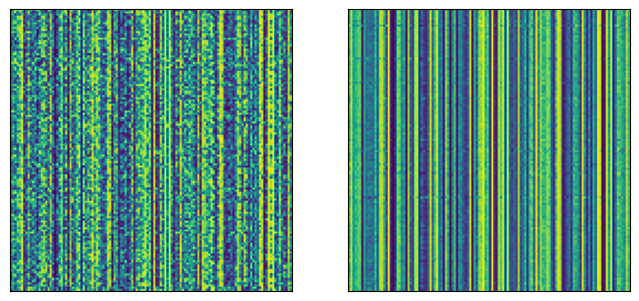

In [500]:
%%time
input = sample # (batch_size, seq_len, input_size): batch_size - time steps in the one sequence - num_sequences
h0_1 = torch.zeros(input.size(0), hidden_size) # time steps in the one sequence - num_sequences ~ for batch_first
h0_2 = torch.zeros(input.size(0), hidden_size)

rnn_cell_layer = RNNCellEx(input_size=input_size, hidden_size=hidden_size, device=device)
att_layer = SimpleAttention1d(input_size=input.size(-1))

for sequence in range(input.size(1)):
    x = att_layer(input[:, sequence, :])
    h0_1 = rnn_cell_layer(x, h0_1)
pred_att_rnn = h0_1

for sequence in range(input.size(1)):
    h0_2 = rnn_cell_layer(input[:, sequence, :], h0_2)
pred_rnn = h0_2

plot_results(pred_rnn.detach(), pred_att_rnn.detach())

In [501]:
class RNNLayer(nn.Module):
    __constants__ = ['input_size', 'hidden_size', 'output_size', 'batch_first', 'num_layers', 'bias', 'nonlinearity', 'attention']

    def __init__(self, input_size: int, hidden_size: int, output_size: int, batch_first: bool = False, num_layers: int = 1,
                 bias: bool = True, nonlinearity: str = 'tanh', attention: bool = False, device: str = 'cpu'):
        super(RNNLayer, self).__init__()
        cond_factory = {'nonlinearity': nonlinearity, 'bias': bias, 'device': device}

        self.num_layers = num_layers
        self.batch_first = batch_first

        self.hidden_size = hidden_size

        self.attention = attention
        if self.attention: self.att_layer = SimpleAttention1d(input_size=input_size, device=device)

        self.rnn_cells = nn.ModuleList()
        self.rnn_cells.append(RNNCellEx(input_size=input_size, hidden_size=hidden_size, **cond_factory)) # input cell
        for _ in range(self.num_layers - 1):
            self.rnn_cells.append(RNNCellEx(input_size=hidden_size, hidden_size=hidden_size, **cond_factory)) # hidden cells

        self.hidden_to_output = LinearEx(in_features=hidden_size, out_features=output_size, bias=bias, device=device)


    def forward(self, inputs: torch.Tensor):
        max_batch_size = inputs.size(0) if self.batch_first else inputs.size(1)
        sequence_len = inputs.size(1) if self.batch_first else inputs.size(0)

        states = torch.autograd.Variable(torch.zeros(size=(self.num_layers, max_batch_size, self.hidden_size)).to(device))
        memory_cell = list(states[layer] for layer in range(self.num_layers))

        if self.batch_first:
            for sequence in range(sequence_len):
                if self.attention: x = self.att_layer(inputs[:, sequence, :])
                else: x = inputs[:, sequence, :]

                for layer in range(self.num_layers):
                    if layer == 0: state = self.rnn_cells[layer](x, memory_cell[layer])
                    else: state = self.rnn_cells[layer](memory_cell[layer - 1], memory_cell[layer])
                    memory_cell[layer] = state

        else:
            for sequence in range(sequence_len):
                if self.attention: x = self.att_layer(inputs[:, sequence, :])
                else: x = inputs[:, sequence, :]

                for layer in range(self.num_layers):
                    if layer == 0: state = self.rnn_cells[layer](inputs[sequence, :, :], memory_cell[layer])
                    else: state = self.rnn_cells[layer](memory_cell[layer - 1], memory_cell[layer])
                    memory_cell[layer] = state

        output = self.hidden_to_output(state)
        return output, memory_cell

In [502]:
model_custom = RNNLayer(input_size=input_size, hidden_size=hidden_size, output_size=num_classes,
                        batch_first=True, num_layers=2, nonlinearity='tanh', attention=True, device=device)
model_custom

RNNLayer(
  (att_layer): SimpleAttention1d(
    (linear): LinearEx()
    (batch_norm): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (softmax): Softmax(dim=1)
  )
  (rnn_cells): ModuleList(
    (0-1): 2 x RNNCellEx(
      (in_to_hidden): LinearEx()
      (hidden_to_hidden): LinearEx()
      (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (hidden_to_output): LinearEx()
)

In [503]:
summary(model_custom, input_size=input.size())

Layer (type:depth-idx)                   Output Shape              Param #
RNNLayer                                 [128, 10]                 --
├─SimpleAttention1d: 1-1                 [128, 28]                 --
│    └─LinearEx: 2-1                     [128, 28]                 812
│    └─BatchNorm1d: 2-2                  [128, 28]                 56
│    └─Softmax: 2-3                      [128, 28]                 --
├─ModuleList: 1-56                       --                        (recursive)
│    └─RNNCellEx: 2-4                    [128, 128]                --
│    │    └─LinearEx: 3-1                [128, 128]                3,712
│    │    └─LinearEx: 3-2                [128, 128]                16,512
│    │    └─LayerNorm: 3-3               [128, 128]                256
│    └─RNNCellEx: 2-5                    [128, 128]                --
│    │    └─LinearEx: 3-4                [128, 128]                16,512
│    │    └─LinearEx: 3-5                [128, 128]            

In [504]:
train_model(
    data=train_dataloader,
    model=model_custom,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model_custom.parameters(), lr=1e-2),
    epochs=3,
    show_step=50
)

Epoch [1/3], Step [50/469], Loss: 1.9581
Epoch [1/3], Step [100/469], Loss: 1.2783
Epoch [1/3], Step [150/469], Loss: 0.8932
Epoch [1/3], Step [200/469], Loss: 0.7898
Epoch [1/3], Step [250/469], Loss: 1.0419
Epoch [1/3], Step [300/469], Loss: 0.6716
Epoch [1/3], Step [350/469], Loss: 0.8368
Epoch [1/3], Step [400/469], Loss: 0.5870
Epoch [1/3], Step [450/469], Loss: 0.6649


Epoch [2/3], Step [50/469], Loss: 0.6396
Epoch [2/3], Step [100/469], Loss: 0.5422
Epoch [2/3], Step [150/469], Loss: 0.4689
Epoch [2/3], Step [200/469], Loss: 0.5323
Epoch [2/3], Step [250/469], Loss: 0.4499
Epoch [2/3], Step [300/469], Loss: 0.7408
Epoch [2/3], Step [350/469], Loss: 0.6896
Epoch [2/3], Step [400/469], Loss: 0.5592
Epoch [2/3], Step [450/469], Loss: 0.4618


Epoch [3/3], Step [50/469], Loss: 0.4729
Epoch [3/3], Step [100/469], Loss: 0.4330
Epoch [3/3], Step [150/469], Loss: 0.5386
Epoch [3/3], Step [200/469], Loss: 0.5902
Epoch [3/3], Step [250/469], Loss: 0.6081
Epoch [3/3], Step [300/469], Loss

In [505]:
print('accuracy on train: %.4f' % accuracy(train_dataloader, model_custom))
print('accuracy on test: %s' % accuracy(test_dataloader, model_custom))

accuracy on train: 0.8111
accuracy on test: 0.802


## Torch RNN

In [506]:
class RNNTorch(nn.Module):
    __constants__ = ['input_size', 'hidden_size', 'output_size', 'num_layers', 'bias', 'batch_first', 'nonlinearity']

    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int = 1, batch_first: bool = False,
                 bias: bool = True, nonlinearity: str = 'tanh', device: str = 'cpu'):
        super(RNNTorch, self).__init__()

        cond_factory = {'nonlinearity': nonlinearity, 'bias': bias, 'device': device}
        self.batch_first = batch_first

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, **cond_factory)

        self.hidden_to_output = nn.Linear(in_features=hidden_size, out_features=output_size, bias=bias, device=device)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        inputs = inputs.to(device)

        self.memory_cell, states = self.rnn(inputs)

        outputs = self.hidden_to_output(self.memory_cell[:, -1, :] if self.batch_first else self.memory_cell[-1, :, :])
        return outputs, states

In [510]:
model_rnn_torch = RNNTorch(input_size=input_size, hidden_size=hidden_size, output_size=num_classes,
                           batch_first=True, num_layers=2, nonlinearity='relu', device=device)
model_rnn_torch

RNNTorch(
  (rnn): RNN(28, 128, num_layers=2, batch_first=True)
  (hidden_to_output): Linear(in_features=128, out_features=10, bias=True)
)

In [511]:
summary(model_rnn_torch, input_size=input.shape)

Layer (type:depth-idx)                   Output Shape              Param #
RNNTorch                                 [128, 10]                 --
├─RNN: 1-1                               [128, 28, 128]            53,248
├─Linear: 1-2                            [128, 10]                 1,290
Total params: 54,538
Trainable params: 54,538
Non-trainable params: 0
Total mult-adds (M): 191.01
Input size (MB): 0.40
Forward/backward pass size (MB): 3.68
Params size (MB): 0.22
Estimated Total Size (MB): 4.30

In [512]:
train_model(
    data=train_dataloader,
    model=model_rnn_torch,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model_rnn_torch.parameters(), lr=1e-2),
    epochs=3,
    show_step=50
)

Epoch [1/3], Step [50/469], Loss: 1.1826
Epoch [1/3], Step [100/469], Loss: 1.1981
Epoch [1/3], Step [150/469], Loss: 1.1041
Epoch [1/3], Step [200/469], Loss: 0.9931
Epoch [1/3], Step [250/469], Loss: 1.1384
Epoch [1/3], Step [300/469], Loss: 0.7407
Epoch [1/3], Step [350/469], Loss: 0.9977
Epoch [1/3], Step [400/469], Loss: 0.9218
Epoch [1/3], Step [450/469], Loss: 0.9230


Epoch [2/3], Step [50/469], Loss: 0.6981
Epoch [2/3], Step [100/469], Loss: 0.6893
Epoch [2/3], Step [150/469], Loss: 0.8326
Epoch [2/3], Step [200/469], Loss: 0.6745
Epoch [2/3], Step [250/469], Loss: 0.7601
Epoch [2/3], Step [300/469], Loss: 0.7793
Epoch [2/3], Step [350/469], Loss: 0.5300
Epoch [2/3], Step [400/469], Loss: 0.7432
Epoch [2/3], Step [450/469], Loss: 0.9083


Epoch [3/3], Step [50/469], Loss: 1.3958
Epoch [3/3], Step [100/469], Loss: 1.1733
Epoch [3/3], Step [150/469], Loss: 0.9142
Epoch [3/3], Step [200/469], Loss: 0.8259
Epoch [3/3], Step [250/469], Loss: 0.7181
Epoch [3/3], Step [300/469], Loss

In [513]:
print('accuracy on train: %.4f' % accuracy(train_dataloader, model_rnn_torch))
print('accuracy on test: %s' % accuracy(test_dataloader, model_rnn_torch))

accuracy on train: 0.7502
accuracy on test: 0.7446
